In [80]:
# export cld_mst

import json
import glob
import subprocess

import cv2
import numpy as np
from matplotlib import pyplot as plt
from shapely import geometry as geom

from math import floor

In [81]:
%load_ext line_profiler
%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [82]:
# default_exp cld_mst

In [90]:
examples = glob.glob('examples/*.png')
examples

['examples\\0162681551.png',
 'examples\\0168366051.png',
 'examples\\0168639352.png']

In [91]:
subprocess.check_call('ls examples')

0

In [92]:
examples = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in examples]

In [93]:
examples[0].shape

(256, 256)

In [94]:
import PIL.Image
import IPython.display

def show(arr):
    IPython.display.display(PIL.Image.fromarray(arr))

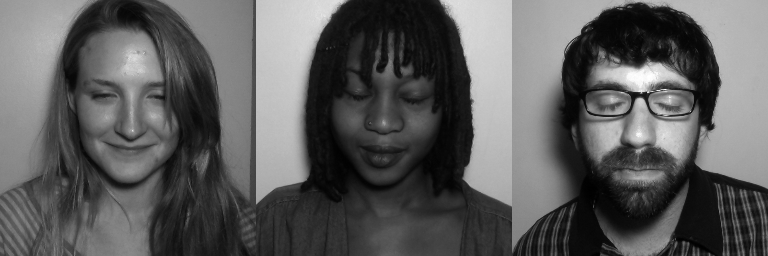

In [95]:
show(np.concatenate(examples, axis=1))

In [96]:
# export cld_mst

from ipywidgets import interact
import os
from tempfile import TemporaryDirectory

def histogram_equalize(data, max_val=None, endpoint=False):
    input_shape = np.shape(data)
    data_flat = np.asarray(data).flatten()
    if max_val is None:
        max_val = data_flat.max()
    indices = np.argsort(data_flat)
    replacements = np.linspace(0, max_val, len(indices), endpoint=endpoint)
    data_flat[indices] = replacements
    return data_flat.reshape(*input_shape)

def _cld(gray, halfw = 8,smoothPasses = 4, sigma1 = .9, sigma2 = 3, tau = .97):
    name = 'cld_tmp_'
    cv2.imwrite(f'{name}_in.bmp', gray)
    subprocess.check_call(f'wsl ./cld {name}_in.bmp {name}_out.bmp {halfw} {smoothPasses} {sigma1} {sigma2} {tau}')
    return cv2.imread(f'{name}_out.bmp', cv2.IMREAD_GRAYSCALE)

def raster_edges(gray, histogram_eq=False, cld=True, canny_low=100, canny_hi=200):
    if histogram_eq:
        gray = histogram_equalize(gray)
        
    edges = 255 - cv2.Canny(gray, canny_low, canny_hi)
    
    if cld:
        edges &= _cld(gray)

    return edges

In [97]:
gray = examples[0]

@interact(histogram_eq=False, cld=True, canny_low=(50, 150), canny_hi=(150, 250))
def _test(histogram_eq, cld, canny_low, canny_hi):
    edges = [raster_edges(ex, histogram_eq, cld, canny_low, canny_hi) for ex in examples]
    return show(np.concatenate(edges, axis=1))

interactive(children=(Checkbox(value=False, description='histogram_eq'), Checkbox(value=True, description='cld…

In [10]:
edges = raster_edges(gray)
cv2.imwrite("output.bmp", edges)
subprocess.check_call(r'.\potrace-1.16.win64\potrace.exe output.bmp -o output.geojson -b geojson')
subprocess.check_call(r'.\potrace-1.16.win64\potrace.exe output.bmp -o output.svg -b svg')

(256, 256) uint8 uint8


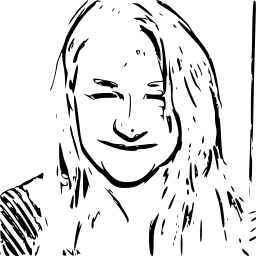

In [11]:
IPython.display.SVG('output.svg')

In [12]:
with open('output.geojson') as fp:
    geojson = json.load(fp)

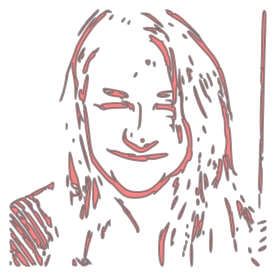

In [13]:
shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
geom.GeometryCollection(shapes)

In [98]:
# export cld_mst

from centerline.geometry import Centerline 
from shapely import ops
import tqdm
def extract_centerlines(shapes):
    shapes = (shape.buffer(0) for shape in shapes)
    polys = [poly for poly in shapes if type(poly) == geom.Polygon and type(poly.envelope) == geom.Polygon]
    centerlines = [Centerline(p, valid=True) for p in polys]
    
    center_geoms = [line.geoms for line in centerlines]
    center_geom_lines = [geom.MultiLineString(line) for line in center_geoms]
    center_geom_lines = [ops.linemerge(line) for line in center_geom_lines]
    return center_geom_lines

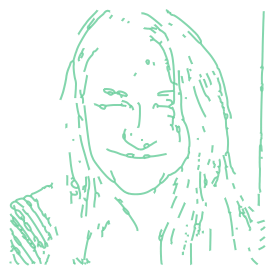

In [99]:

# profile: 
# %lprun -u 0.001 -f extract_centerlines geom.GeometryCollection(extract_centerlines(shapes))
center_geom_lines = extract_centerlines(shapes)
geom.GeometryCollection(center_geom_lines)

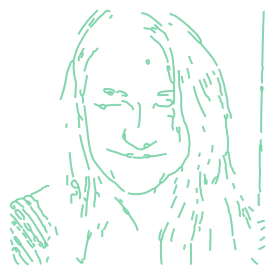

In [15]:
# export cld_mst

def explode_multilines(lines):
    out = []
    for line in lines:
        if type(line) == geom.multilinestring.MultiLineString:
            out.extend(subline for subline in line)
        else:
            out.append(line)
    return out

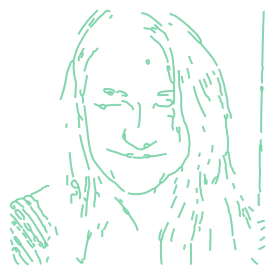

In [100]:
center_geom_lines = explode_multilines(center_geom_lines)

center_geom_lines = [line for line in center_geom_lines 
                     if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

geom.GeometryCollection(center_geom_lines)

In [101]:
# export cld_mst

def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

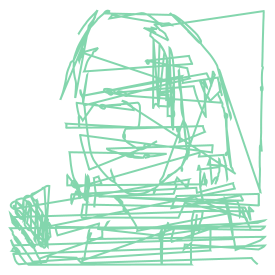

In [102]:
merge_naive(center_geom_lines)

In [103]:
# export cld_mst

from math import sqrt

def greedy_reorder(lines):
    ''' Reorder list of LineStrings greedily by lowest tail-tip distance'''
    lines = lines[:]
    curr = lines.pop(0)
    out = []
    while len(lines) > 0:
        start_curr = geom.Point(curr.coords[0])
        end_curr = geom.Point(curr.coords[-1])
        dist = float('+inf')
        nearest_tail = None
        for other in lines:
            start_o = geom.Point(other.coords[0])
            end_o = geom.Point(other.coords[-1])
            if end_curr.distance(start_o) < dist:
                dist = end_curr.distance(start_o)
                nearest_tail = other
            elif end_curr.distance(end_o) < dist:
                dist = end_curr.distance(end_o)
                other.coords = list(other.coords)[::-1]
                nearest_tail = other
        lines.remove(nearest_tail)
        out.append(nearest_tail)
        curr = nearest_tail
    return out

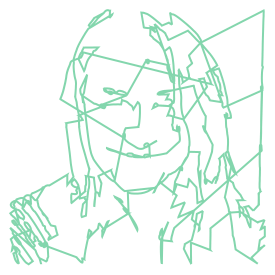

In [104]:
ordered_lines = greedy_reorder(center_geom_lines)
merge_naive(ordered_lines)

We can try ordering the lines by their distance to the center as the first paths in the list have more next-lines to chose from, and so hopefully the center of the face will get the best "picks".
We can also try ordering by start point closest to center or end point closest to center

In [105]:
# export cld_mst

def reorder_center_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(line.centroid)
    return sorted(lines, key=dist)


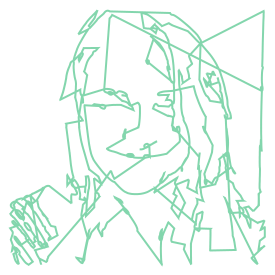

In [106]:

ordered_by_closest_to_center = reorder_center_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

In [107]:
# export cld_mst

def reorder_start_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[0]))
    return sorted(lines, key=dist)


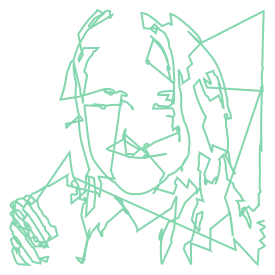

In [108]:

ordered_by_closest_to_center = reorder_start_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

In [109]:
# export cld_mst

def reorder_end_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[-1]))
    return sorted(lines, key=dist)

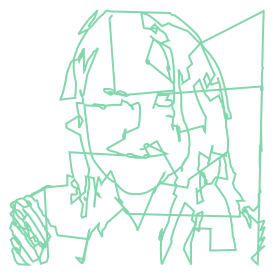

In [110]:
ordered_by_closest_to_center = reorder_end_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

In [21]:
import scipy.sparse.csgraph as csgraph

In [22]:
1+1

2

In [23]:
np.arange(0, 5)

array([0, 1, 2, 3, 4])

In [111]:
# export cld_mst

def sobel(gray):
    scale = 1
    delta = 0
    ddepth = cv2.CV_32FC1

    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

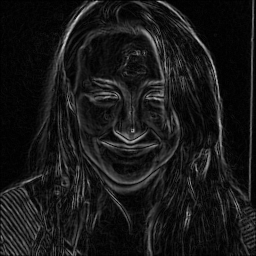

In [112]:
grad = sobel(gray)
show(grad)

In [113]:
grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)
grad_blurred /= grad_blurred.max()

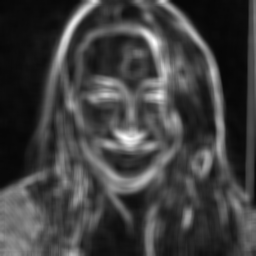

In [114]:
show((grad_blurred * 255).astype(np.uint8))

In [191]:
# export cld_mst

import numpy as np

def sample_grad(grad_blurred):
    gp = grad_blurred.copy()
    gp[gp < (gp.mean() + 0.5 * gp.std())] = 0.0
    prob = gp
    sample_at = (np.random.poisson(prob + 0.001, (256, 256)) > 0).astype(np.uint8)
    
    sampled_grad_pixels = grad_blurred * sample_at
    sampled_grad_pixels[0, 0] = 1
    sampled_grad_pixels[-1, -1] = 1
    sampled_grad_pixels[0, -1] = 1
    sampled_grad_pixels[-1, 0] = 1
    
    return sampled_grad_pixels


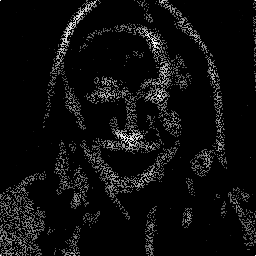

In [192]:
sampled_grad_pixels = sample_grad(grad_blurred)
show((sampled_grad_pixels * 255).astype(np.uint8))

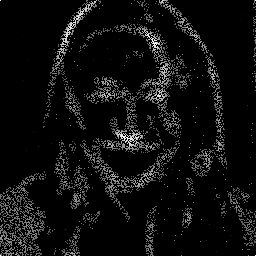

In [203]:
for line in center_geom_lines:
    s = line.coords[0]
    e = line.coords[-1]
    sampled_grad_pixels[255 - floor(s[1]), floor(s[0])] = 0.5
    sampled_grad_pixels[255 - floor(e[1]), floor(e[0])] = 0.5
    
show((sampled_grad_pixels * 255).astype(np.uint8))

In [224]:
# export cld_mst

import scipy.spatial

def triangulate(sampled_grad_pixels):
    nonzero_ys, nonzero_xs = np.nonzero(sampled_grad_pixels)
    nonzero_coords = np.dstack((nonzero_ys, nonzero_xs)).squeeze().astype(np.float32)
    tri = scipy.spatial.Delaunay(nonzero_coords)
    
    z = np.zeros_like(sampled_grad_pixels)
    p = tri.points.astype(np.int)
    vals = np.nonzero(sampled_grad_pixels)
    z[p[:, 0], p[:, 1]] = sampled_grad_pixels[vals[0], vals[1]]
    return tri, z
    

In [225]:
tri.points

array([[255.,   0.],
       [255.,  86.],
       [255.,  87.],
       ...,
       [  0., 181.],
       [  0., 248.],
       [  0., 255.]])

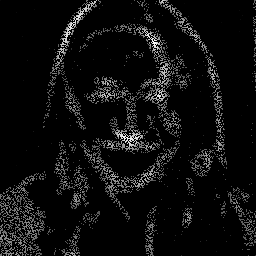

In [248]:
z = np.zeros_like(sampled_grad_pixels)
p = tri.points.astype(np.int)
vals = np.nonzero(sampled_grad_pixels)
z[p[:, 0], p[:, 1]] = grad_blurred[vals[0], vals[1]]
show((z * 255).astype(np.uint8))

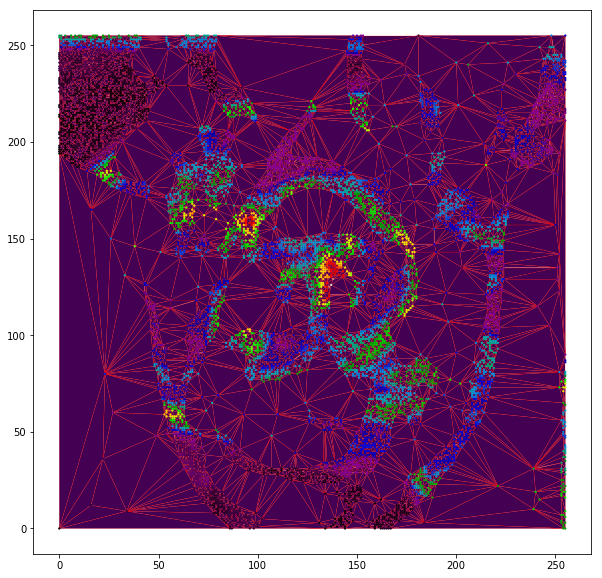

In [230]:

tri, _ = triangulate(sampled_grad_pixels)
pixel_vals = grad_blurred[tri.points[:, 1].astype(np.int),  tri.points[:, 0].astype(np.int)]

plt.figure(figsize=(10, 10))
plt.tripcolor(tri.points[:, 1], tri.points[:, 0], tri.simplices, np.ones_like(pixel_vals), edgecolor="red")
plt.scatter(tri.points[:, 1], tri.points[:, 0], c=pixel_vals, cmap='nipy_spectral', s=1.5)

In [231]:
# export cld_mst

def to_graph(tri):
    nbrs = {i:set() for i in range(len(tri.points))}

    for smplx in tri.simplices:
        nbrs[smplx[0]].add(smplx[1])
        nbrs[smplx[1]].add(smplx[2])
        nbrs[smplx[2]].add(smplx[0])

        nbrs[smplx[1]].add(smplx[0])
        nbrs[smplx[2]].add(smplx[1])
        nbrs[smplx[0]].add(smplx[2])
    
    return nbrs

In [232]:
graph = to_graph(tri)
graph[896]

{874, 875, 911, 932}

In [233]:
# export cld_mst

import heapq
from collections import defaultdict

def extract_path_rec(from_key, to_key, reverse_paths, out_list):
    next_key = reverse_paths[from_key]
    
    if next_key != to_key and next_key in reverse_paths:
        extract_path_rec(next_key, to_key, reverse_paths, out_list)
        
    out_list.append(next_key)
    return out_list

def extract_path(from_key, to_key, reverse_paths):
    path = extract_path_rec(from_key, to_key, reverse_paths, [])
    path.append(from_key)
    return path

def a_star(start_vertex, goal_vertex, graph, weight, heuristic, return_len=False):
    if start_vertex == goal_vertex:
        return [start_vertex, goal_vertex]
    q = [(0, start_vertex)]
    possible_nexts = set([start_vertex])
    reverse_paths = {}
    cheapest_paths = defaultdict(lambda: float('+inf'))
    cheapest_total = defaultdict(lambda: float('+inf'))
    cheapest_paths[start_vertex] = 0
    while len(possible_nexts) > 0:
        curr_f, curr = heapq.heappop(q)
        possible_nexts.remove(curr)
        if curr == goal_vertex:
            path = extract_path(goal_vertex, start_vertex, reverse_paths)
            if return_len:
                return path, cheapest_paths[goal_vertex]
            else:
                return path
        
        if curr not in graph:
            continue
        nbrs = graph[curr]
        
        for nbr in nbrs:
            h = weight(curr, nbr)
            maybe_best_g = h + cheapest_paths[curr]
            if cheapest_paths[nbr] > maybe_best_g:
                reverse_paths[nbr] = curr
                cheapest_paths[nbr] = maybe_best_g
                f = maybe_best_g + heuristic(nbr, goal_vertex)
                if nbr not in possible_nexts:
                    possible_nexts.add(nbr)
                    heapq.heappush(q, (f, nbr))

In [234]:
# export cld_mst

import time
from math import sqrt 

def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

def pt_vert_distance(pt, tri, idx):
    return sqrt(tuple_sq_dist(pt, tri.points[idx]))

def nearest_line(pt, lines, remaining_line_idxs):
    nearest = None
    nearest_idx = None
    flip = False
    closest_dist = 1e10
    for idx in remaining_line_idxs:
        other = lines[idx]
        start_dist = tuple_sq_dist(pt, other.coords[0])
        end_dist = tuple_sq_dist(pt, other.coords[-1])
        if start_dist < closest_dist:
            flip = False
            closest_dist = start_dist
            nearest = other
            nearest_idx = idx
        elif end_dist < closest_dist:
            flip = True
            closest_dist = end_dist
            nearest = other
            nearest_idx = idx
    return nearest, nearest_idx, flip


def mk_heuristic_fn(tri, grad_blurred):
    
    grad_max = grad_blurred.max()

    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    def heuristic(i, goal):
        dist = distance(i, goal)
        coords = tri.points[i].astype(np.int)
        edginess = grad_blurred[coords[1], coords[0]]
        return dist
    return heuristic

def mk_weight_fn(tri, grad_blurred):
    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    grad_max = grad_blurred.max()

    def weight(i, j):
        dist = distance(i, j) ** 1.5
        i_pos = tri.points[i]
        j_pos = tri.points[j]

        mid = (i_pos + j_pos).astype(np.int) // 2
        i_pos = i_pos.astype(np.int)
        j_pos = j_pos.astype(np.int)
        edginess = (grad_blurred[mid[1], mid[0]] + grad_blurred[i_pos[1], i_pos[0]] + grad_blurred[j_pos[1], j_pos[0]])/3.0
        return dist + (1.0 - edginess)*10
    return weight

def tuple_sq_dist(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return (dx*dx) + (dy*dy)
    
    
def insert_a_star_connections(lines, tri, graph_copy, grad_blurred):
    weight = mk_weight_fn(tri, grad_blurred)
    heuristic = mk_heuristic_fn(tri, grad_blurred)
    remaining_lines = set(range(len(lines)))
    curr_idx = 0
    out = [lines[curr_idx]]
    remaining_lines.remove(curr_idx)
    pts_added = []
    while len(remaining_lines) > 0:
        curr = lines[curr_idx]
        end_curr = curr.coords[-1]
        dist = float('+inf')
        nearest_tail, nearest_tail_idx, flip = nearest_line(end_curr, lines, remaining_lines)
        
        if flip:
            nearest_tail.coords = list(nearest_tail.coords)[::-1]

        remaining_lines.remove(nearest_tail_idx)
        
        next_start_x, next_start_y = nearest_tail.coords[0]
        goal_pos = next_start_x, next_start_y
        
        goal_smplx_idx = tri.find_simplex(goal_pos)
        goal_smplx = tri.simplices[goal_smplx_idx]
        nearest_smplx_corner_to_goal = min(goal_smplx, key=lambda idx: pt_vert_distance(goal_pos, tri, idx))
        
        curr_smplx_idx = tri.find_simplex(end_curr)
        curr_smplx = tri.simplices[curr_smplx_idx]
        nearest_smplx_corner_to_curr = min(curr_smplx, key=lambda idx: pt_vert_distance(end_curr, tri, idx))
        
        if (nearest_smplx_corner_to_goal != nearest_smplx_corner_to_curr
            and nearest_smplx_corner_to_goal in graph_copy
            and nearest_smplx_corner_to_curr in graph_copy):
            path_between = a_star(nearest_smplx_corner_to_curr, nearest_smplx_corner_to_goal, graph_copy, weight, heuristic)
            
            if path_between is not None:
                for i in range(len(path_between) - 1):
                    p_i = path_between[i]
                    p_next = path_between[i + 1]
                    graph_copy[p_i].remove(p_next)
                    #del graph_copy[p_i]
                    #print('del', p_i)

                pts_between = [tuple(tri.points[idx]) for idx in path_between]
                pts_added.append(geom.LineString(pts_between))
                out.append(geom.LineString(pts_between))
            else:
                print("no path")
        out.append(nearest_tail)
        curr_idx = nearest_tail_idx
    return out, pts_added


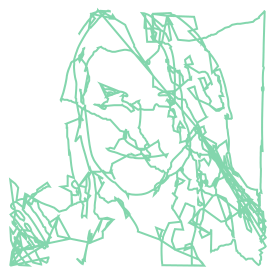

In [235]:
#profile:
# %lprun -u 0.001 -f nearest_line insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)
# %lprun -u 0.001 -f a_star insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)
# %lprun -u 0.001 -f insert_a_star_connections insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)

graph = to_graph(tri)
a_star_connected, added_pts = insert_a_star_connections((center_geom_lines), tri, graph, grad_blurred)
merged = merge_naive(a_star_connected)
merged

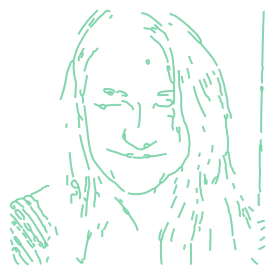

In [236]:
geom.GeometryCollection(center_geom_lines)

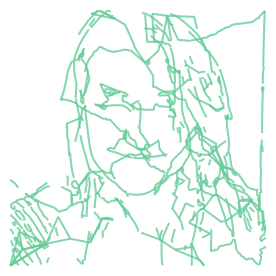

In [237]:
geom.GeometryCollection(a_star_connected)

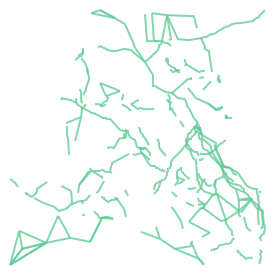

In [238]:
geom.GeometryCollection(added_pts)

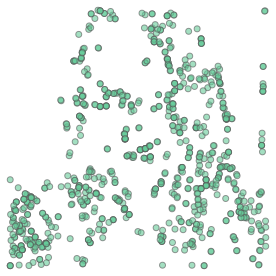

In [239]:
geom.GeometryCollection([geom.Point(line.coords[0]) for line in a_star_connected] + 
                        [geom.Point(line.coords[-1]) for line in a_star_connected])

In [240]:
import descartes as des

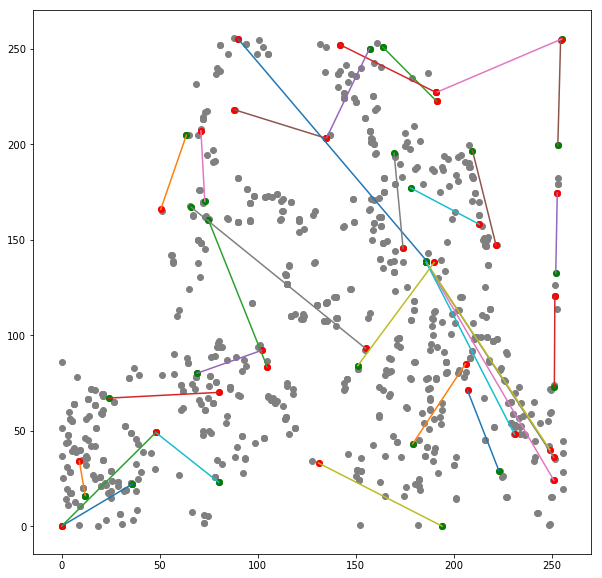

In [241]:
starts = np.asarray([line.coords[0] for line in a_star_connected])
ends = np.asarray([line.coords[-1] for line in a_star_connected])
length = np.asarray([line.length for line in a_star_connected])

long_starts = starts[length > 40]
long_ends = ends[length > 40]

plt.figure(figsize=(10, 10))
plt.scatter(starts[:, 0], starts[:, 1], c='gray')
plt.scatter(ends[:, 0], ends[:, 1], c='gray')
plt.scatter(long_starts[:, 0], long_starts[:, 1], c='green')
plt.scatter(long_ends[:, 0], long_ends[:, 1], c='red')

for start, end in zip(long_starts, long_ends):
    plt.plot([start[0], end[0]], [start[1], end[1]])

(array([137., 119.,  68.,  27.,  26.,   9.,   9.,   7.,   3.,   7.,   0.,
          2.,   3.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   3.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  1.41421356,   6.85519789,  12.29618221,  17.73716654,
         23.17815086,  28.61913519,  34.06011951,  39.50110384,
         44.94208816,  50.38307249,  55.82405681,  61.26504114,
         66.70602547,  72.14700979,  77.58799412,  83.02897844,
         88.46996277,  93.91094709,  99.35193142, 104.79291574,
        110.23390007, 115.67488439, 121.11586872, 126.55685304,
        131.99783737, 137.43882169, 142.87980602, 148.32079034,
        153.76177467, 159.20275899, 164.64374332]),
 <a list of 30 Patch objects>)

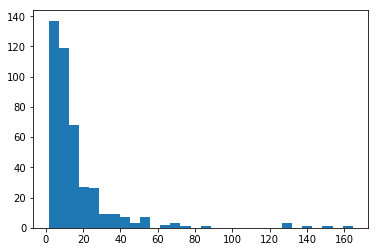

In [242]:
plt.hist(length, bins=30)

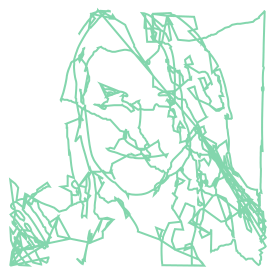

In [243]:
merged

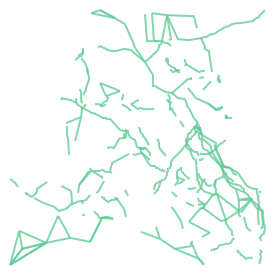

In [244]:
geom.GeometryCollection(added_pts)

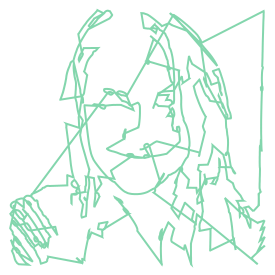

In [245]:

merge_naive(greedy_reorder(reorder_center_dist(center_geom_lines)))

1. make few canny edges
2. solve for path
3. pick connectors from dense edges

aka

1. make lots of canny edges
2. solve for path by picking points in between ends and snapping them to nearest lines

or

1. make edges
2. a* w/ heuristics based on edgi-ness of pixel along delauncy triangulion of face or polar grid

+

1. centerline optimization

In [246]:
# export cld_mst

def pipeline(gray):
    
    edges = raster_edges(gray)
    edges[:, 240:] = 255
    edges[:, :16] = 255
    edges[:16, :] = 255
    edges[240:]
    
    cv2.imwrite('trace_in.bmp', edges)
    subprocess.check_call(r'.\potrace-1.16.win64\potrace.exe trace_in.bmp -o trace_out.geojson -b geojson')
    
    with open('trace_out.geojson') as fp:
        geojson = json.load(fp)

    shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
    
    center_geom_lines = extract_centerlines(shapes)

    center_geom_lines = explode_multilines(center_geom_lines)

    center_geom_lines = [line for line in center_geom_lines 
                         if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    grad = sobel(gray)

    grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

    grad_samples = sample_grad(grad_blurred)

    tri, grad_samples = triangulate(grad_samples)

    graph = to_graph(tri)
    
    a_star_connected, added_pts = insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph, grad_blurred)
    merged = merge_naive(a_star_connected)
    return merged

def rgb2line(img):
    rgb = np.asarray(img)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    line = pipeline(gray)
    return line.__geo_interface__
    


In [247]:
#%lprun -u 0.001 -f pipeline pipeline(examples[0])
 # %lprun -u 0.001 -f insert_a_star_connections pipeline(examples[0])

In [163]:
len(center_geom_lines)

272

In [214]:
out = pipeline(examples[0])
out

In [215]:
out.__geo_interface__

{'type': 'LineString',
 'coordinates': ((114.82660051613108, 126.65701164873214),
  (114.84274924169905, 126.60418499384285),
  (114.94251096711939, 126.39394404166801),
  (114.9972859665516, 126.21588705127058),
  (115.06380613587307, 126.07522364159809),
  (115.18610001121993, 125.89082467444238),
  (115.30580216590104, 125.63748357328168),
  (115.56291060552724, 125.25045575332032),
  (115.57842687886075, 125.21776037727807),
  (115.80848255130854, 124.87135642716893),
  (115.97276367440652, 124.68699777566316),
  (115.97383995190413, 124.6860869848036),
  (116.3061411112545, 124.31434351119047),
  (116.56732369104876, 124.09389851229764),
  (116.67554774135169, 123.9734797113495),
  (116.92710617902566, 123.76062388184653),
  (117.04370028407112, 123.63150936382229),
  (117.2790622361517, 123.43186662392776),
  (117.28146360170662, 123.42921801504292),
  (117.60509639288233, 123.15455075852785),
  (117.68622295795436, 123.10213685273352),
  (117.99454904902399, 122.84061681925205),

In [165]:
import numpy as np
import scipy.interpolate as interpolate

def smooth(line, simplify=5.0, resample=10):

    x, y = line.simplify(simplify).coords.xy
    t = np.arange(len(x))
    ti = np.linspace(0, t.max(), resample * t.size)

    xi = interpolate.interp1d(t, x, kind='cubic')(ti)
    yi = interpolate.interp1d(t, y, kind='cubic')(ti)

    return geom.asLineString(np.dstack((xi, yi)).squeeze())

@interact(simplify=(0.0, 30.0), resample=(1, 10))
def _test(simplify, resample):
    return smooth(out, simplify, resample)

interactive(children=(FloatSlider(value=15.0, description='simplify', max=30.0), IntSlider(value=5, descriptio…

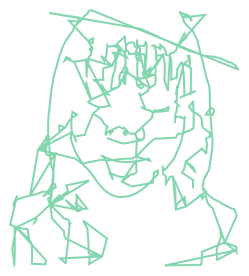

In [166]:
pipeline(examples[1])

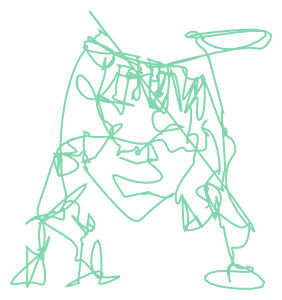

In [167]:
smooth(pipeline(examples[1]), 4.0, 4)

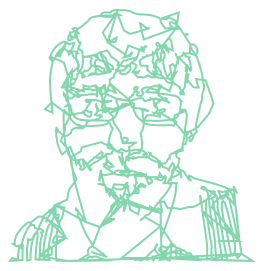

In [168]:
pipeline(examples[2])

In [212]:
beardglasses = pipeline(examples[2])


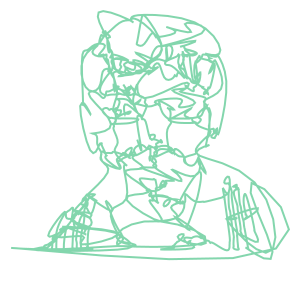

In [213]:
smooth(beardglasses, 50.0, 4)

# next steps
1. make server
2. dense canny
3. splat on dlib face tracker
3. figure out consistent edge parameters
    1. histogram eq, hp filter
    2. take ROI from face, try M taus, find one that has some constant number of variance/num edges
    3. diff cld params for diff regions of face (e.g low tau in center, high tau outside)
4. see smoothed vector edges after astar
5. figure out flow field of edges, align lines with neighbours
6. try just connecting endpoints w/ ok to go over lines already one then solve path on top of that
7. ? order lines by epicycles / curvature ?
    1. fit a limited number of bezier/circle arc to line, compute err
8. Just throw in all the edges from the triangulation and original image and find the MST but you also don't wanna visit the triangulation verticies
    1. approx astar cost in mst computation

In [ ]:
gray = examples[0]    
edges = raster_edges(gray)
edges[:, 240:] = 255
edges[:, :16] = 255

cv2.imwrite("tmp.bmp", edges)
subprocess.check_call(r'.\potrace-1.16.win64\potrace.exe tmp.bmp -o tmp.geojson -b geojson')

with open('tmp.geojson') as fp:
    geojson = json.load(fp)

shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]

center_geom_lines = extract_centerlines(shapes)

center_geom_lines = explode_multilines(center_geom_lines)

center_geom_lines = [line for line in center_geom_lines 
                     if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]


In [ ]:
from math import floor

grad = sobel(gray)

grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

grad_samples = sample_grad(grad_blurred)

for line in center_geom_lines:
    s = line.coords[0]
    e = line.coords[-1]
    grad_samples[floor(s[0]), floor(s[1])] = 1
    grad_samples[floor(e[0]), floor(e[1])] = 1

tri = triangulate(grad_samples)

tri_graph = to_graph(tri)

weight = mk_weight_fn(tri, grad_blurred)
heuristic = mk_heuristic_fn(tri, grad_blurred)

center_geom_lines = reorder_start_dist(center_geom_lines)

In [ ]:
data = []
ss = []
ts = []

def w(i, j):
    start = tri.points[i]
    end = tri.points[j]
    mid = np.floor((start + end) / 2).astype(np.int)
    gf = 1.0 - grad_blurred[mid[1], mid[0]]
    dist = np.linalg.norm(start - end)
    return gf * dist

for s, nbrs in tri_graph.items():
    for t in nbrs:
        ss.append(s)
        ts.append(t)
        data.append(w(s, t))
mat = scipy.sparse.coo_matrix((data, (ss, ts))).tocsc()

In [ ]:
distances, preds = scipy.sparse.csgraph.dijkstra(mat, return_predecessors=True)

In [ ]:
def extract_path_preds(preds, i, j):
    path = [j]
    k = j
    while preds[i, k] != -9999:
        path.append(preds[i, k])
        k = preds[i, k]
    return path[::-1]

In [ ]:
def nearest_vertex(tri, pt):
    curr_smplx_idx = tri.find_simplex(pt)
    curr_smplx = tri.simplices[curr_smplx_idx]
    nearest_smplx_corner_to_curr = min(curr_smplx, key=lambda idx: pt_vert_distance(pt, tri, idx))            
    return nearest_smplx_corner_to_curr

In [ ]:
shortest_paths = {}
graph = {}

tri_verts = [(nearest_vertex(tri, line.coords[0]), nearest_vertex(tri, line.coords[-1])) for line in center_geom_lines]
remaining_idxes = set(range(len(tri_verts)))

starts = np.asarray([v[0] for v in tri_verts])
ends = np.asarray([v[1] for v in tri_verts])

lines = []

curr = 0

added_lines = []

for curr in range(len(tri_verts)):
    
    start_idx, end_idx = tri_verts[curr]
    
    # both in same simplex
    if start_idx == end_idx:
        lines.append(center_geom_lines[curr])
        continue
    
    
    closest_dist = float("+inf")
    closest_tri_idx = None
    closest_idx = None
    for i, other_start in enumerate(starts):
        if i == curr:
            continue
        if distances[end_idx, other_start] < closest_dist:
            closest_dist = distances[end_idx, other_start]
            closest_tri_idx = other_start
            closest_idx = i
    
    lines.append(center_geom_lines[curr])
    
    path_verts = extract_path_preds(preds, end_idx, closest_tri_idx)
    
    if len(path_verts) > 1:
        as_pts = [center_geom_lines[curr].coords[-1]] + [tri.points[i] for i in path_verts] \
            + [center_geom_lines[closest_idx].coords[0]]
        
        # as_pts = [tri.points[i] for i in path_verts]
        
        lines.append(geom.LineString(np.asarray(as_pts)))
        
        #lines.append(geom.LineString(np.asarray(as_pts)).buffer(closest_dist))
        added_lines.append(geom.LineString(np.asarray(as_pts)))


In [ ]:
geom.GeometryCollection(lines)

In [ ]:
geom.GeometryCollection(added_lines)

In [ ]:
len(center_geom_lines)

In [ ]:
shortest_paths = {}

tri_verts = [(nearest_vertex(tri, line.coords[0]), nearest_vertex(tri, line.coords[-1])) for line in center_geom_lines]
remaining_idxes = set(range(len(tri_verts)))

starts = np.asarray([v[0] for v in tri_verts])
ends = np.asarray([v[1] for v in tri_verts])

lines = []

curr = 0

added_lines = []

for curr in range(len(tri_verts)):
    
    start_idx, end_idx = tri_verts[curr]
    
    # both in same simplex
    if start_idx == end_idx:
        lines.append(center_geom_lines[curr])
        continue
    
    for i, other_start in enumerate(starts):
        if i == curr:
            continue
        graph[curr, i] = distances[end_idx, other_start]
        shortest_paths[curr, i] = extract_path_preds(preds, end_idx, other_start)


In [ ]:
graph_is = []
graph_js = []
graph_weights = []

for (i, j), w in graph.items():
    if i != j:
        graph_is.append(i)
        graph_js.append(j)
        graph_weights.append(w)

graph_is = np.asarray(graph_is)
graph_js = np.asarray(graph_js)
graph_weights = np.asarray(graph_weights)

In [ ]:
over_mat = scipy.sparse.coo_matrix((graph_weights, (graph_is, graph_js))).tocsc()
over_distances, over_preds = scipy.sparse.csgraph.dijkstra(over_mat, return_predecessors=True, )

In [ ]:
len(tri_verts), over_preds.shape

In [ ]:
scipy.sparse.csgraph.reconstruct_path()

In [ ]:
lines = []
added_lines = []
for curr in range(len(tri_verts)):
    closest_dist = float("+inf")
    closest_idx = None
    for i, d in enumerate(over_distances[curr]):
        if curr == i:
            continue
        if d < closest_dist:
            closest_dist = d
            closest_idx = i

    pred = over_preds[closest_idx, curr]
    
    lines.append(center_geom_lines[curr])
    if closest_idx is not None:
        path_verts = extract_path_preds(preds, ends[curr], starts[closest_idx])
        as_pts = [center_geom_lines[curr].coords[-1]] + [tri.points[i] for i in path_verts] \
            + [center_geom_lines[closest_idx].coords[0]]
        added_lines.append(geom.LineString(as_pts))

In [ ]:
geom.GeometryCollection(lines + added_lines)

In [ ]:
(32 * 32 * 4) ** 2

In [ ]:
dist_mat = over_distances
cities = over_distances
# from https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy

# Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
path_distance = lambda r,c: np.sum([
    dist_mat[r[p], r[p+1]] for p in range(len(r)-1)
])
# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.

route = two_opt(cities, 0.1)

In [ ]:
lines = []
added_lines = []
for i, line_idx in enumerate(route):
    start, end = tri_verts[line_idx]
    lines.append(center_geom_lines[line_idx])
    if i == len(route) - 1:
        break
    
    next_idx = route[i + 1]
    next_start, next_end = tri_verts[next_idx]
    
    if next_end == start:
        continue
        
    path_verts = extract_path_preds(preds, end, next_start)
    as_pts = np.stack([tri.points[i] for i in path_verts])
    if len(as_pts) > 1:
        added_lines.append(geom.LineString(as_pts))

In [ ]:
geom.GeometryCollection(lines + added_lines)

In [ ]:
geom.GeometryCollection(added_lines)

In [ ]:
import numba

def intergrate_spring(xy, out, mass, k, damp):
    tail_delta = np.array([0, 0])
    tail_pos = xy[0] + tail_delta
    vec = np.array([0, 0])
    for i in range(xy.shape[0]):
        pos = xy[i]
        tail_delta = pos - tail_pos
        force = -k * tail_delta
        accel = force / mass
        vel += accel
        vel *= damp
        tail_pos += vel
        out[i] = tail_pos